# VHH phage display panning against intact _P. aeruginosa_ cells (`fig:panning-hts`)

In [1]:
import nbseq
import os

# change working directory to `./panning-small` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
import pandas as pd, numpy as np

import plotnine
from plotnine import *

import matplotlib
import matplotlib.pyplot as plt

In [3]:
import nbseq.viz.sample as nvs
import nbseq.viz.tree
import nbseq.ft as nbft
from nbseq.utils import replace_multiple
from nbseq.viz.utils import extract_encoded_data_plotnine

In [4]:
# setup matplotlib to render figures as SVG with editable text preserved at appropriate font size
FONT_SIZE = 5

plt.rcParams.update({
    "font.family":"sans",
    "font.size": FONT_SIZE,
    "svg.fonttype": "none"
})

In [5]:
%config InlineBackend.figure_formats = ['svg']

In [6]:
# manipulate metadata for this older experiment into newer format expected by nbseq

metadata = pd.read_csv('config/metadata-full.tsv',sep="\t")
phenotypes = pd.read_csv('config/phenotypes.csv').fillna(0).set_index(['genotype_CS', 'genotype_S'])
# phenotypes = phenotypes.fillna(0)

metadata['_idx'] = range(len(metadata))
metadata['method'] = metadata['method'].fillna('blank')
metadata['replicate'] = metadata['replicate'].fillna(1).astype(int)
metadata = metadata.sort_values(by=['expt','sample','round','replicate'])
meta_phenotypes = pd.merge(
    left=metadata,
    right=phenotypes,
    left_on=['genotype_CS', 'genotype_S'],
    right_index=True,
    how='left'
)

phenotype_cols = list(phenotypes.columns)
meta_phenotypes[phenotype_cols] = meta_phenotypes[phenotype_cols].fillna(0)
meta_phenotypes = meta_phenotypes.set_index('ID',drop=True)
meta_phenotypes.to_csv('config/metadata-phenotypes.csv')
metadata = meta_phenotypes

In [7]:
ex = nbseq.Experiment.from_files(metadata='config/metadata-phenotypes.csv', phenotypes=None, ft_aa=None)

Loading experiment panning-small from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-small'...
- Reading metadata from config/metadata-phenotypes.csv ...
- Warning: no phenotypes table given.
- Reading Config from config/config.yaml ...
- Warning: sqlite database '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-small/intermediate/aa/asvs.db' does not exist
- Reading feature data for table 'cdr3' from results/tables/cdr3/asvs.csv (45.8 MB)...
- Reading cdr3 feature table from results/tables/cdr3/feature_table.biom (48.4 MB)...
- Warning: phylogeny for space 'aa' at 'intermediate/aa/features/top_asvs/alpaca/asvs.nwk' does not exist!
- Warning: phylogeny for space 'cdr3' at 'intermediate/cdr3/features/top_asvs/alpaca/asvs.nwk' does not exist!
- Warning: mmseqs2 database for space 'aa' at 'intermediate/aa/features_db/features' does not exist!
- Warning: mmseqs2 database for space 'cdr3' at 'intermediate/cdr3/features_db/features' does not exist!
- Warning: enrichm

In [8]:
ex

Experiment('panning-small') with feature spaces ['cdr3']:
  obs: ['plate' 'well' 'depth' 'expt' 'round' 'sample' 'phage_library' 'notes'
    'r' 'io' 'kind' 'selection' 'replicate' 'name_full' 'name' 'method'
    'genotype_CS' 'background_CS' 'strain_CS' 'genotype_S' 'background_S'
    'strain_S' 'bio_Notes' 'category' 'antigen' 'genotype_pair' 'gene_CS'
    'gene_S' 'notebook' 'description' '_idx' 'flagellum' 'pilin' 'T3SS'
    'efflux' 'alginate' 'pel/psl']
- cdr3    : 981 samples x 748401 features, database: None
  var: ['CDR3' 'library' 'reads' 'nsamples']
SQL: sqlite:////vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-small/intermediate/aa/asvs.db

Shorten antigen descriptions for ease of readability

In [9]:
ex.fts.cdr3.obs['antigen_description'] = replace_multiple(
    ex.fts.cdr3.obs.apply(lambda x: "{background_S} {antigen}".format(**x), axis=1),
    {
        "MB5919 all efflux": "efflux",
        "PAO1 Parsek pel/psl": "PAO1 Pel/Psl"
    })

## Rank-abundance (Whittaker) plots

In [10]:
def whittaker(ex, expt, library, space='cdr3', predicates='', line=dict(size=1), layers = [], **kwargs):
    query = f"expt == '{expt}' & phage_library == '{library}' & replicate == 1 & io == 'i' & kind == '+'"
    if predicates != '':
        query += f" & ({predicates})"
    ft = ex.query(query, space=space)

    g = nvs.rank_abundance_plot(ft, line=line, **kwargs) + layers
    g.save(f"results/plots/rank_abundance/{expt}.svg")
    extract_encoded_data_plotnine(g).to_csv(f"results/tables/figures/rank_abundance/{expt}.csv", index=False)
    return g

In [11]:
# format X axis as "1k", "2k", etc.
from matplotlib.ticker import EngFormatter

fmt = EngFormatter(sep="")
def order_facets(column, order):
    def _reorder(df):
        df[column] = df[column].astype("category").cat.reorder_categories(order)
        return df
    return _reorder

# plot formatting
layers = [
    scale_color_cmap_d("viridis"),
    scale_x_continuous(name="feature rank", labels=lambda x: list(map(fmt.format_eng, x))),
    facet_wrap("antigen_description", nrow=1),
    theme_bw(), 
    theme(
        legend_key_height=4,
        legend_key_width=4,
        text=element_text(family='sans', size=5)
    ),
    guides(color=guide_legend(title="round"))
]

In [12]:
%%bash
mkdir -p results/plots/rank_abundance/
mkdir -p results/tables/figures/rank_abundance

### Solid-phase panning

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 1.5 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/rank_abundance/032h.svg


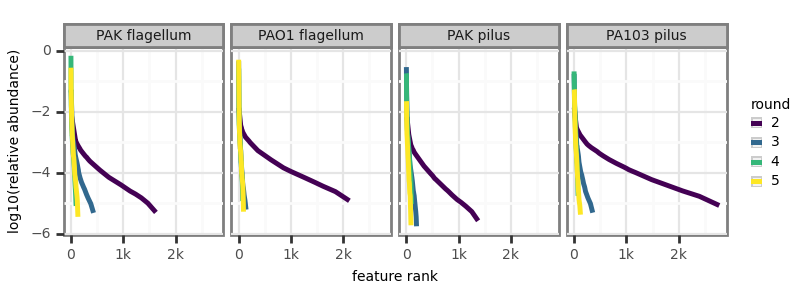

<Figure Size: (400 x 150)>

In [13]:
g = whittaker(ex, '032h','Alpaca', color="r", 
              n_sample=dict(n=20, replace=True),
              transform=order_facets("antigen_description", ["PAK flagellum", "PAO1 flagellum", "PAK pilus", "PA103 pilus"]),
              layers = layers + [theme(figure_size=(4,1.5))]
             )
g

### Cell-based pannings

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 1.5 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/rank_abundance/024e.svg


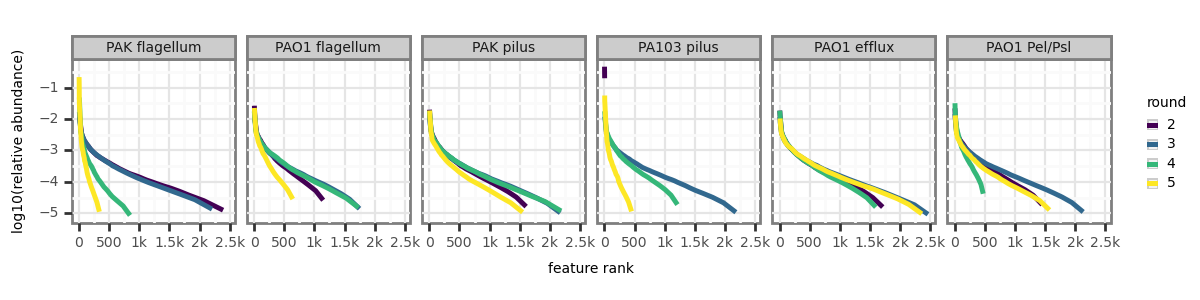

<Figure Size: (600 x 150)>

In [14]:
g = whittaker(
    ex, '024e','Alpaca', predicates="sample != '7' & sample != '8'", 
    n_sample=dict(n=100, replace=True),
    line=dict(size=1),
    color="r",
    transform=order_facets("antigen_description", ["PAK flagellum", "PAO1 flagellum", "PAK pilus", "PA103 pilus", "PAO1 efflux", "PAO1 Pel/Psl"]),
    layers = layers + [theme(figure_size=(6,1.5))]
) 
g

## Bar Plots

In [15]:
%%bash
mkdir -p results/plots/barplots/
mkdir -p results/tables/figures/barplots/

In [16]:
def plot_expt(ex, expt, library, predicates='', space='cdr3', samples=None, layers=[], **kwargs):
    query = f"expt == '{expt}' & phage_library == '{library}' & replicate == 1 & io == 'i' & kind == '+'"
    if predicates != '':
        query += f" & ({predicates})"
    ft = ex.query(query, space=space)
    if samples is None:
        expt_samples = ft.obs['sample'].unique()
    else:
        expt_samples = samples
    print(expt_samples)
    dfs = []
    for sample in expt_samples:
        
        # print(nbft.query(ft, f"sample == '{sample}'", axis='sample').obs.r)
        # print(nbft.query_ids(ft, f"sample == '{sample}' & r == '5'"))
        
        ft_expt = nvs.collapse_top_asvs(
            ft, 
            samples = nbft.query_ids(ft, f"sample == '{sample}'"),
            top_from_samples = nbft.query_ids(ft, f"sample == '{sample}' & r == '5'"),
            n = 40,
            relative=True)
        
        first_row = ft_expt.obs.iloc[0,:]
        # print("{background_S} {antigen} - {method}".format(**first_row))
        # print(ft_expt)

        df = nbft.fortify(ft_expt, obs=True)
        
        _plot = (nvs.top_asv_barplot(df, feature_name=space.upper(), **kwargs) 
              + ggtitle(title="{background_S} {antigen} - {method}".format(**first_row)) 
              + theme(figure_size=(4,4)))
        _plot += layers


        
        import os
        fn = "{background_S}_{antigen}_{method}".format(**first_row).replace(os.path.sep,"_")
        _plot.save("results/plots/barplots/" + fn + ".svg")

        dfs.append(extract_encoded_data_plotnine(_plot))
        
        display(_plot)
    pd.concat(dfs).to_csv(f"results/tables/figures/barplots/{expt}.csv", index=None)

In [17]:
layers = [
    scale_x_discrete(name='round',expand=(0,0)),
    scale_y_continuous(name='relative abundance', expand=(0,0)),
    theme_bw(), 
    theme(
    figure_size=(3,2),
    legend_key_height=4,
    legend_key_width=4,
    text=element_text(family='sans', size=5))]

### Solid-phase panning

['1', '2', '4']


/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/PAK_flagellum_solid.svg


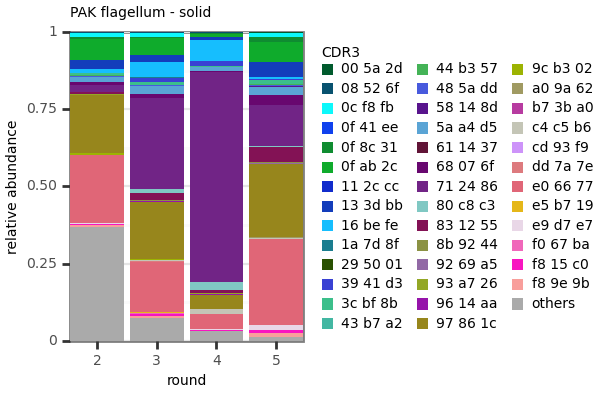

<Figure Size: (300 x 200)>

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/PAO1_flagellum_solid.svg


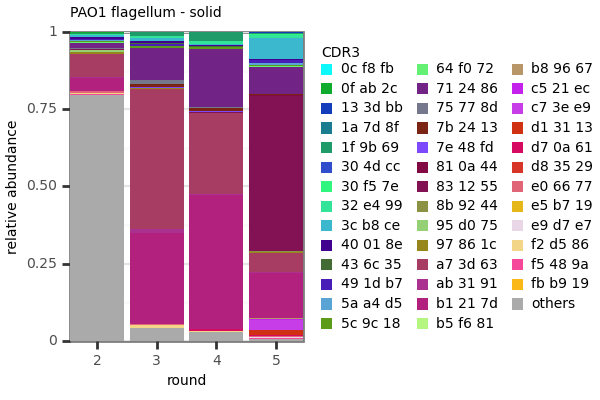

<Figure Size: (300 x 200)>

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/PAK_pilus_solid.svg


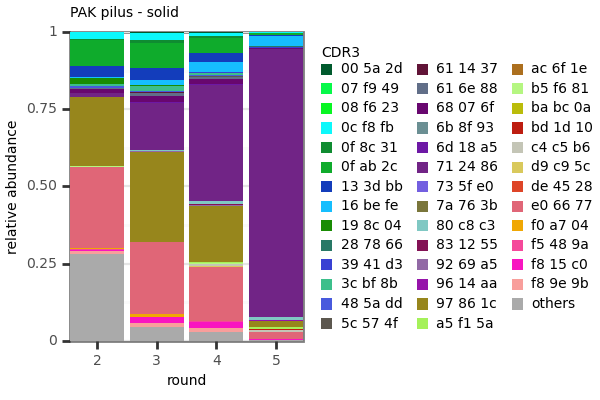

<Figure Size: (300 x 200)>

In [18]:
plot_expt(ex,'032h','Alpaca', samples=['1','2','4'], layers=layers)

### Cell-based pannings

['1', '2', '3']


/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/PAK_flagellum_cell_tube.svg


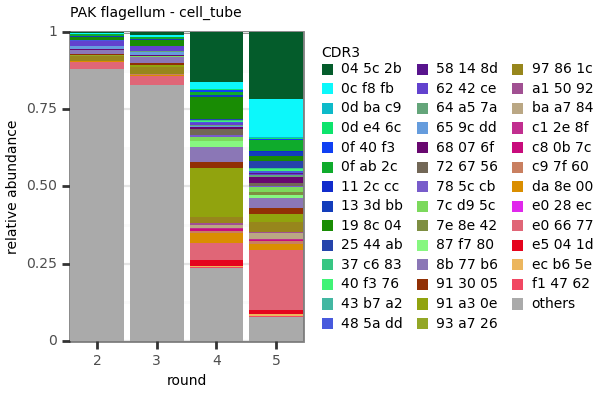

<Figure Size: (300 x 200)>

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/PAO1_flagellum_cell_tube.svg


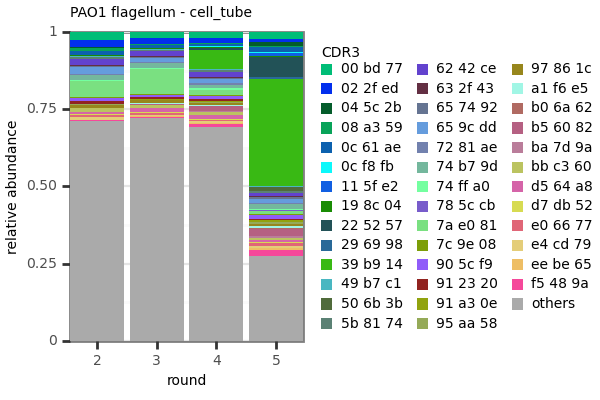

<Figure Size: (300 x 200)>

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/PA103_pilus_cell_tube.svg


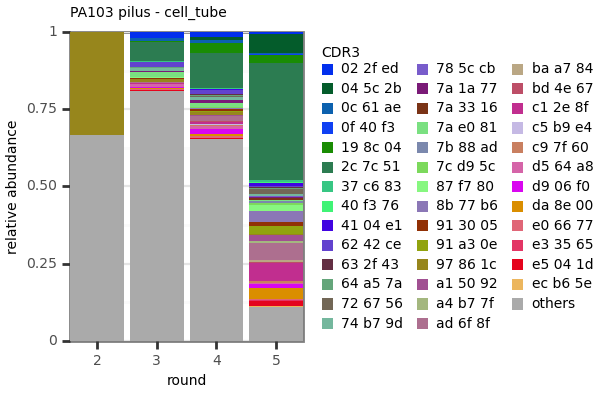

<Figure Size: (300 x 200)>

In [19]:
plot_expt(ex,'024e','Alpaca',layers=layers, samples=['1','2','3'])